In [1]:
#항상 불러와야되는거
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
sns.set()

##### 머신러닝 프로세스
- 문제정의
- 데이터 수집
- 데이터 전처리
- EDA(탐색적 데이터 분석)
- 모델 선택 및 하이퍼파라미터 튜닝
- 모델 학습
- 모델 평가
- 서비스화

### 1. 문제 정의
- 타이타닉 탑승객 정보를 학습해서 생존자 / 사망자 분류( 이진분류)
- 지도학습방법

### 2. 데이터 수집
- kaggle 사이트에서 다운로드

In [5]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
display(test)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


### 3. 데이터 전처리
- 결측치 처리 세밀하게 진행하자
- binning 작업 해보자
- 비정형 데이터(Name)정형화 해보자
- 인코딩 (one-hot-encoding)을 해보자..

##### Age 결측치 채우기
- 전체 데이터에 대한 기술 통계가 아니라 세밀한 데이터 그룹 만들어서 결측치 채우기

In [6]:
train.corr()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


- Age와 반비례 관계가 컬럼 중 가장 강력한 것은 Pclass이다
- Age가 올라가면 Pclass는 떨어지는 관계

In [7]:
train["Age"].median() # 나이의 중앙값

28.0

In [8]:
train[["Age", "Pclass"]].groupby(by="Pclass").median()

,Age
Pclass,
1,37.0
2,29.0
3,24.0


In [10]:
age_tbl=train[["Age", "Pclass","Sex"]].groupby(by=["Pclass", "Sex"]).median()

In [11]:
age_tbl.loc[3]

,Age
Sex,
female,21.5
male,25.0


In [12]:
age_tbl.loc[(2,"female")]#multi index

Age    28.0
Name: (2, female), dtype: float64

##### apply 함수
- DataFrame이나 Series를 행 열단위로 반복할때
- 복잡한 알고리즘 만들어 적용할때 사용

In [25]:
def fill_age(row):
    if np.isnan(row["Age"]): #결측치 유무
        return age_tbl.loc[(row["Pclass"],row["Sex"])][0]
    else :
        return row["Age"]
    

In [27]:
train["Age"]=train.apply(fill_age , axis=1)
test["Age"]=test.apply(fill_age,axis=1)

##### Fare, Embarked
- 결측치 수가 별로 없다. 전체 데이터의 기술통계값으로 채우자

In [29]:
display(train["Embarked"].mode())


0    S
dtype: object

In [30]:
train["Embarked"].fillna(train["Embarked"].mode()[0], inplace=True)
test["Embarked"].fillna(test["Embarked"].mode()[0], inplace=True)
train["Fare"].fillna(train["Fare"].mode()[0], inplace=True)
test["Fare"].fillna(train["Fare"].mean(), inplace=True)

### cabin 결측치 처리하기
- 결측치를 하나의 데이터로 인정하고, 모델에 학습을 시켜 볼수도 있다

In [32]:
train["Cabin"].fillna("Missing", inplace=True)
test["Cabin"].fillna("Missing", inplace=True)

In [34]:
train["Cabin"].unique()

array(['Missing', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [36]:
train["Cabin"]=train["Cabin"].str[0]

In [37]:
test["Cabin"]=test["Cabin"].str[0]

#### 4.EDA(탐색적 데이터 분석)

-Sibsp,Parch 시각화

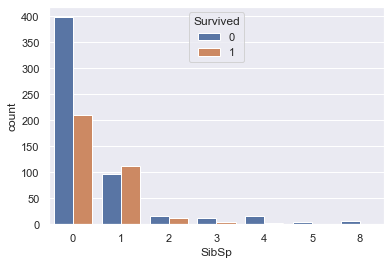

In [40]:
# 데이터의 갯수를 세서
sns.countplot(data=train, x="SibSp", hue="Survived")

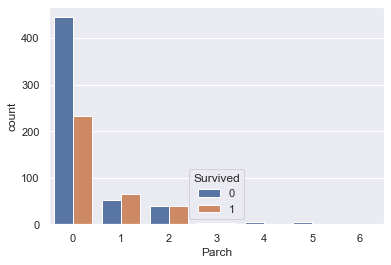

In [41]:
sns.countplot(data=train, x="Parch", hue="Survived")

In [42]:
# 특성공학
train["Family"]=train["SibSp"]+train["Parch"]

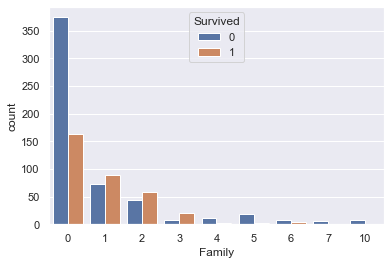

In [43]:
sns.countplot(data=train, x="Family", hue="Survived")

- 가족이 0명일 때 죽을 호가률이 높다
- 가족이 1~3명일 때 살 확률이 높다
- 가족이 4명 이상일때 죽을 확률이 높다
- 가족은 수치형 데이터 타입이다
- 구간화 작업을 통해 범주형 데이터로 만들고 모델에게 특성을 강조하자

### binning

In [54]:
data=train["Family"]
bins=[-1,1,4,20]
categori=["Alone", "Small", "Large"]
train["Family_cut"]=pd.cut(data, bins=bins, labels=categori)
test["Family"]=test["SibSp"]+test["Parch"]
data=test["Family"]
test["Family_cut"]=pd.cut(data, bins=bins, labels=categori)



display(train["Family_cut"].value_counts().to_frame().style.background_gradient(cmap='Pastel1'))
display(test["Family_cut"].value_counts().to_frame().style.background_gradient(cmap='YlGnBu'))

,Family_cut
Alone,698
Small,146
Large,47


,Family_cut
Alone,327
Small,78
Large,13


In [53]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   PassengerId  418 non-null    int64   
 1   Pclass       418 non-null    int64   
 2   Name         418 non-null    object  
 3   Sex          418 non-null    object  
 4   Age          418 non-null    float64 
 5   SibSp        418 non-null    int64   
 6   Parch        418 non-null    int64   
 7   Ticket       418 non-null    object  
 8   Fare         418 non-null    float64 
 9   Cabin        418 non-null    object  
 10  Embarked     418 non-null    object  
 11  Family       418 non-null    int64   
 12  Family_cut   418 non-null    category
dtypes: category(1), float64(2), int64(5), object(5)
memory usage: 39.8+ KB


# 비정형데이터(Name) 정형화

In [55]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Family,Family_cut
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,M,S,1,Alone
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,1,Alone
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,M,S,0,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,1,Alone
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,M,S,0,Alone


In [57]:
def split_title(name):
    return name.split(",")[1].split(".")[0].strip()

In [58]:
train["Title"]=train["Name"].apply(split_title)
test["Title"]=test["Name"].apply(split_title)

In [60]:
display(train["Title"])
display(train["Title"])

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

# 인코딩(문자타입 -> 숫자타입)
- 원힛인코딩 : 순서가 없는 범주형 데이터를 0과 1로 표현하느방법
- 순서가 없으면 one-hot Encoding
- 순서가 있으면 Label Encoding
- 순서가 없는 애들에게  Label Encoding을 하면 순서가 부여된다

In [61]:
pd.get_dummies(train["Sex"])

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
...,...,...
886,0,1
887,1,0
888,1,0
889,0,1


In [62]:
pd.get_dummies(train["Embarked"])

,C,Q,S
0,0,0,1
1,1,0,0
2,0,0,1
3,0,0,1
4,0,0,1
...,...,...,...
886,0,0,1
887,0,0,1
888,0,0,1
889,1,0,0


In [63]:
pd.get_dummies(train["Cabin"], prefix="Cabin")

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T
0,0,0,0,0,0,0,0,1,0
1,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,1,0
887,0,1,0,0,0,0,0,0,0
888,0,0,0,0,0,0,0,1,0
889,0,0,1,0,0,0,0,0,0


In [64]:
pd.get_dummies(train[["Cabin", "Embarked"]])

,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_M,Cabin_T,Embarked_C,Embarked_Q,Embarked_S
0,0,0,0,0,0,0,0,1,0,0,0,1
1,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,1,0,0,0,1
3,0,0,1,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,0,0,0,0,1,0,0,0,1
887,0,1,0,0,0,0,0,0,0,0,0,1
888,0,0,0,0,0,0,0,1,0,0,0,1
889,0,0,1,0,0,0,0,0,0,1,0,0
